# Capstone Project: Star Trek IMDB Ratings Predictor - Katya Kogan - Part 2
--- 
## Introduction

Now we've successfully cleaned and prepared our data, we can begin our modelling process to determine if the characters (by their spoken parts) contribute to the `imdbRating`. 

Since we are focusing on feature importance, our models will have to be carefully chosen, as this is a regression problem - so we'll use Regression models such as: Linear Regression, Decision Tree Regressor, Random Forest Regressor, SVM (Regressor), OrdinalRidge Regression (MORD), Least Absolute Deviation (MORD), and Gradient Boosting Regressor. 

We'll be performing baseline tests across these models, and then find the one performs that best and fine-tune parameters, which afterwords - we'll be testing the precision and recall of them. 

We'll begin by importing all the relevant libraries needed for our project. 

In [1]:
# importing the basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
#ML libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#Importing Mord library
from mord import LogisticIT, LogisticAT, LAD, OrdinalRidge

# libraries for splitting and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import linear_model as lm, metrics, tree, ensemble, model_selection as ms, feature_selection, svm

pd.options.mode.chained_assignment = None 

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

With our libraries imported, we can begin by reading in our dataset, do some minor EDA and prep before starting to fit our models. 

In [2]:
ST_df = pd.read_csv(r"C:\Users\Katya\Documents\GitHub\Capstone-Project---BrainStation\PCT_Graph.csv")

In [3]:
ST_df.head()

,Unnamed: 0,PICARD_PCT,RIKER_PCT,DATA_PCT,WORF_PCT,TROI_PCT,BEVERLY_PCT,GEORDI_PCT,Q_PCT,LORE_PCT,WESLEY_PCT,GUINAN_PCT,TASHA_PCT,PULASKI_PCT,RATING
0,0,33.46,31.58,10.44,1.69,0.00,4.26,5.21,6.05,0.0,4.52,0.0,2.79,0.00,8.000000
1,1,11.47,3.01,26.08,25.44,14.94,4.23,14.82,0.00,0.0,0.00,0.0,0.00,0.00,7.996689
2,2,27.32,42.75,7.88,8.60,0.00,0.00,0.00,0.00,0.0,10.20,0.0,0.00,3.25,8.000000
3,3,39.13,24.34,11.60,1.94,3.09,0.92,16.36,0.00,0.0,2.63,0.0,0.00,0.00,7.000000
4,4,41.64,9.67,18.77,5.32,2.31,5.44,16.85,0.00,0.0,0.00,0.0,0.00,0.00,7.000000


Now we've successfully imported our dataframe, we can see that there is still some minor cleaning to do. We'll have to drop the `Unnamed: 0` column. 

In [4]:
# dropping the Unnamed: 0 column
ST_df.drop(labels='Unnamed: 0', inplace=True, axis=1)

In [5]:
# sanity check
ST_df.head()

,PICARD_PCT,RIKER_PCT,DATA_PCT,WORF_PCT,TROI_PCT,BEVERLY_PCT,GEORDI_PCT,Q_PCT,LORE_PCT,WESLEY_PCT,GUINAN_PCT,TASHA_PCT,PULASKI_PCT,RATING
0,33.46,31.58,10.44,1.69,0.00,4.26,5.21,6.05,0.0,4.52,0.0,2.79,0.00,8.000000
1,11.47,3.01,26.08,25.44,14.94,4.23,14.82,0.00,0.0,0.00,0.0,0.00,0.00,7.996689
2,27.32,42.75,7.88,8.60,0.00,0.00,0.00,0.00,0.0,10.20,0.0,0.00,3.25,8.000000
3,39.13,24.34,11.60,1.94,3.09,0.92,16.36,0.00,0.0,2.63,0.0,0.00,0.00,7.000000
4,41.64,9.67,18.77,5.32,2.31,5.44,16.85,0.00,0.0,0.00,0.0,0.00,0.00,7.000000


Great, we've dropped the unnecessary column. Let's take a quick look at the rating distribution, once more. 

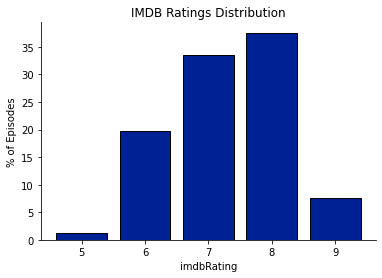

In [6]:
# looking at the distribution of the IMDB Ratings
values, counts = np.unique(ST_df['RATING'], return_counts=True)
normalized_reviews = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_reviews * 100, edgecolor='black', color='#002193')
plt.xlabel('imdbRating')
plt.ylabel('% of Episodes')
sns.despine()
plt.title("IMDB Ratings Distribution")
plt.savefig("IMDB Ratings Distribution")
plt.show()

Now we'll take a renewed look at the `RATING` column, and make sure all the values are rounded up correctly (and remains a float). 

In [7]:
# double check
ST_df['RATING'].unique()

array([8.        , 7.99668874, 7.        , 6.        , 9.        ,
       5.        ])

In [8]:
# rounding up the rating values
ST_df['RATING'] = round(ST_df['RATING'])

In [9]:
# sanity check 
ST_df['RATING'].unique()

array([8., 7., 6., 9., 5.])

In [10]:
# check the type
ST_df['RATING'].dtype

dtype('float64')

Moving on, we can be confident going ahead with splitting the data set into train and test sets.

After the splitting is completed, the training set(s) will be fit and transformed. Sidenote: the testing data shouldn't be mixed with the fit and transformation of the data. The fitting and transformation process will be applied separately to the `RATING` column.

Essentially:

1. Split `ST_df` into train and test sets
2. With the fitted `RATING`, transform the `RATING` column for both X_train and X_test

We'll begin by defining our X and y values:

X : all columns except for `RATING` (independent)
y : contains only `RATING` (dependent)

In [11]:
# separate df into features and target variable
y = ST_df['RATING']
# drop the target variable from the X dataframe (remaining features)
X = ST_df.drop('RATING',axis=1)

Now that we've separated the independent and dependent variables from each other, now we'll performing a train test split using a test size of 30%.

In [12]:
# split the data into train and test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7, shuffle=True)

In [13]:
# class proportion in the original
print("Original Data Proportions")
print(y.value_counts()/len(y), '\n')

# class proportion in the training data
print("Training Data Proportions")
print(y_train.value_counts()/len(y_train), '\n')

# class proportion of the testing data
print("Testing Data Proportions")
print(y_test.value_counts()/len(y_test), '\n')

Original Data Proportions
8.0    0.381503
7.0    0.335260
6.0    0.196532
9.0    0.075145
5.0    0.011561
Name: RATING, dtype: float64 

Training Data Proportions
8.0    0.380165
7.0    0.338843
6.0    0.198347
9.0    0.074380
5.0    0.008264
Name: RATING, dtype: float64 

Testing Data Proportions
8.0    0.384615
7.0    0.326923
6.0    0.192308
9.0    0.076923
5.0    0.019231
Name: RATING, dtype: float64 



It's good practice to standardise the predicative variables, especially for liner regressions. We'll fit and transform on the training set, and transform on the testing set. 

In [14]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
print("Length of training sets:",len(X_train), len(X_test))
print("Length of testing sets:",len(y_train), len(y_test))

Length of training sets: 121 52
Length of testing sets: 121 52


### Modelling Workflow 

Now that we've successfully split the data set into their respective train and test datasets, we can commence comfortably with modelling. 

Our workflow will be:
- Linear Regression
- Decision Tree Regression
- Random Forest Regression
- SVM Regressor
- OrdinalRidge Regression
- LAD 

Let's start with the baseline models, determine which ones perform the best and then start tuning the hyperparameters. Since we're testing a myriad of models, I decided to create a function where it'll take in the train-test data, and the model type in order to return the default model scores. It'll return the train-test scores (using RMSE as an evaluation metric), cross validation scores, and the mean cross validation score. 

In addition to this, another function will also be created for regularising/hyperparameter optimization once we've selected our model to dive deeper into. 

Let's create our simple model metrics function, as well as our empty lists to store the results. 

In [15]:
# creating our lists to store the results of our default models 
training_score = []
testing_RMSE = []
mean_cross_val_score = [] 

In [16]:
# Function to return simple model metrics
def simple_model_metrics(X_train, y_train, X_test, y_test, model, parametric=True):
    '''Takes in train test splits and the model type, and returns the training and test score (RMSE),
    cross-validation scores, and the mean cross-validation score. Returns the feature importances if the 
    argument "parametric" is True or False''' 
    
    # fit the model
    model.fit(X_train, y_train)
    
    # predict the models
    train_pred = np.around(model.predict(X_train),1)
    test_pred = np.around(model.predict(X_test),1)
    
    # print results using RMSE for train and test scores
    print('Training RMSE', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, train_pred))))
    print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, test_pred))))
    
    # append train and testing scores to list
    training_score.append('{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, train_pred))))
    testing_RMSE.append('{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, test_pred))))
    
    # acquire the cross validation score (neg mean squared error), 5 folds
    cv_scores = -ms.cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # print results of the cross val RMSEs, and the mean cross val RMSE
    print('Cross-validated RMSEs:', np.sqrt(cv_scores))
    print('Mean cross-validated RMSE:', '{0:0.2f}'.format(np.sqrt(np.mean(cv_scores))))
    
    # appending mean cross val RMSE to list
    mean_cross_val_score.append('{0:0.2f}'.format(np.sqrt(np.mean(cv_scores))))
    
    # conditions if parametric is true or false
    if parametric == True:
        # prints a dataframe containing the X train cols, model coefficients and absolute coefficient
        print(pd.DataFrame(list(zip(X_train.columns, model.coef_, abs(model.coef_))), 
                 columns=['Feature', 'Coef', 'Abs Coef']).sort_values('Abs Coef', ascending=False).head(10))
    else:
        # prints a dataframe containing the X train cols and model feature importances
        print(pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), 
                 columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).head(10))
    
    return model

#### Baseline RMSE
With our function created, now we can use it quite simply and with ease. However, we don't know what baseline to compare the RMSE scores with. This score explains what you would get if the mean value for the `y` was predicted. Essentially, if the model does better than this score - it's a good start! 

Let's check what the baseline is. 

In [17]:
y_pred_mean = [y_train.mean()] * len(y_test)

print("Baseline score RMSE: ",'{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))))

Baseline score RMSE:  0.93


The baseline score is an RMSE of 0.93, meaning that the predicted score is within 0.93 of a mark out of 1. This is a baseline to compare the performance of my models. The current RMSE suggests that there is variance in the data that would lead to this outcome. 

Since this is a regression problem, we're referring to the Root Mean Squared Error as our score dimension. We'll be focusing on the models that have the best performing cross-validation scores, while taking into consideration of the training and test scores (checking for underfitting or overfitting). 

To intrepret the RMSE, the rule of thumb is that if the predicted and true values differ by a large margin - the RMSE will be large. If the RMSE is close to 0, it's nearing a perfect fit of the data. 

To start us off, we'll begin with a few simple models and compare their scores (default). Once we determine which one performs the best, we'll dive into it a bit deeper with a pipeline (using a function). 

#### Linear Regression

In [18]:
linear_default = simple_model_metrics(X_train, y_train, X_test, y_test, LinearRegression())
linear_default

Training RMSE 0.81
Testing RMSE: 0.87
Cross-validated RMSEs: [1.00363983 0.94040328 0.99844307 0.90575722 0.97937206]
Mean cross-validated RMSE: 0.97
        Feature        Coef    Abs Coef
0    PICARD_PCT -213.374965  213.374965
2      DATA_PCT -160.190173  160.190173
6    GEORDI_PCT -139.984872  139.984872
5   BEVERLY_PCT -134.309799  134.309799
1     RIKER_PCT -125.320469  125.320469
4      TROI_PCT -123.563818  123.563818
3      WORF_PCT -118.513233  118.513233
7         Q_PCT -104.318121  104.318121
9    WESLEY_PCT  -67.013172   67.013172
11    TASHA_PCT  -42.593696   42.593696


LinearRegression()

But the training and test RMSEs are a bit high, and the cross validation score is higher than our baseline. This suggests that the model is underfit, and regularisation could help with improving these results, but let's explore the other options first before we attempt to tune the parameters. 

#### Decision Tree Regressor

In [19]:
tree_default = simple_model_metrics(X_train, y_train, X_test, y_test, DecisionTreeRegressor(), False)
tree_default

Training RMSE 0.00
Testing RMSE: 1.14
Cross-validated RMSEs: [1.14891253 1.30703226 1.42886902 1.32287566 1.2416387 ]
Mean cross-validated RMSE: 1.29
        Feature  Importance
3      WORF_PCT    0.209085
4      TROI_PCT    0.196536
0    PICARD_PCT    0.094095
5   BEVERLY_PCT    0.091613
11    TASHA_PCT    0.087755
2      DATA_PCT    0.062841
1     RIKER_PCT    0.062197
9    WESLEY_PCT    0.061832
10   GUINAN_PCT    0.053058
6    GEORDI_PCT    0.040012


DecisionTreeRegressor()

The training score is 0, and the testing score is exceedingly high. This suggests that this model is extremely overfit. We won't be considering this as an option to persue. 

#### Random Forest Regressor

In [20]:
forest_default = simple_model_metrics(X_train, y_train, X_test, y_test, RandomForestRegressor(), False)
forest_default

Training RMSE 0.35
Testing RMSE: 0.87
Cross-validated RMSEs: [1.01899951 0.84941647 0.94805063 0.94192843 0.88329638]
Mean cross-validated RMSE: 0.93
        Feature  Importance
3      WORF_PCT    0.205968
4      TROI_PCT    0.145247
0    PICARD_PCT    0.111536
1     RIKER_PCT    0.098299
6    GEORDI_PCT    0.082832
5   BEVERLY_PCT    0.079360
2      DATA_PCT    0.070417
9    WESLEY_PCT    0.062094
11    TASHA_PCT    0.061400
10   GUINAN_PCT    0.047818


RandomForestRegressor()

The training and test scores are both lower than the baseline is, including the cross validation score (by 0.01). This is already showing signs of a good fit, and this model is currently our best option. 

#### Support Vector Machines (Regressor)

In [21]:
# instantiate the model
svr_default = svm.SVR()

#fit the model
svr_default.fit(X_train, y_train)

# print results from training and testing RMSE
print('Training RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, svr_default.predict(X_train)))))
print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, svr_default.predict(X_test)))))

# append train and testing scores to lists
training_score.append('{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, svr_default.predict(X_train)))))
testing_RMSE.append('{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, svr_default.predict(X_test)))))

# acquire the cross validation scores
cv_scores = -ms.cross_val_score(svr_default, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# printing the results of the cross val scores and the mean cross val score
print('Cross-validated RMSEs:', cv_scores)
print('Mean cross-validated RMSE:', '{0:0.2f}'.format(np.mean(cv_scores)))

# appending mean cross val RMSE to list
mean_cross_val_score.append('{0:0.2f}'.format(np.sqrt(np.mean(cv_scores))))

Training RMSE: 0.62
Testing RMSE: 0.94
Cross-validated RMSEs: [0.79023991 0.77991106 0.67043417 0.72753278 0.81789065]
Mean cross-validated RMSE: 0.76


The training score is lower than our baseline, with the testing score matching the baseline. However, the cross validation score is what's stealing the show. With a RMSE of 0.76, this suggests to me that this model is another worthy contention worth persuing further. 

---

There is a package that is dedicated for Ordinal Regression (goal is to predict a variable that is discrete and ordered). Referring to this [documentation](https://pythonhosted.org/mord/#regression-based), we'll test the defaults of the MORD package and see how it compares against the other models from sklearn. 

#### OrdinalRidge Regression - MORD

In [22]:
mord_ordinal_default = simple_model_metrics(X_train, y_train, X_test, y_test, OrdinalRidge())
mord_ordinal_default

Training RMSE 0.85
Testing RMSE: 0.93
Cross-validated RMSEs: [1.07703296 0.95742711 1.09924216 0.88975652 1.08012345]
Mean cross-validated RMSE: 1.02
        Feature      Coef  Abs Coef
10   GUINAN_PCT  0.197785  0.197785
9    WESLEY_PCT -0.185553  0.185553
4      TROI_PCT -0.144367  0.144367
11    TASHA_PCT -0.131599  0.131599
12  PULASKI_PCT -0.102575  0.102575
8      LORE_PCT  0.089497  0.089497
5   BEVERLY_PCT -0.086334  0.086334
1     RIKER_PCT  0.082768  0.082768
3      WORF_PCT  0.062255  0.062255
0    PICARD_PCT  0.058793  0.058793


OrdinalRidge()

Even though the training and testing RMSE are lower than our baseline, the cross validation is way too high. We won't be considering this as an option. 

---
#### LAD (Least Absolute Deviation) - MORD

In [23]:
mord_lad_default = simple_model_metrics(X_train, y_train, X_test, y_test, LAD())
mord_lad_default

Training RMSE 0.88
Testing RMSE: 0.94
Cross-validated RMSEs: [1.07703296 1.         0.91287093 0.93541435 1.17260394]
Mean cross-validated RMSE: 1.02
        Feature      Coef  Abs Coef
4      TROI_PCT -0.218031  0.218031
11    TASHA_PCT -0.188546  0.188546
10   GUINAN_PCT  0.183016  0.183016
12  PULASKI_PCT -0.177696  0.177696
3      WORF_PCT  0.175703  0.175703
6    GEORDI_PCT  0.137086  0.137086
5   BEVERLY_PCT -0.130370  0.130370
9    WESLEY_PCT -0.119352  0.119352
2      DATA_PCT  0.082285  0.082285
8      LORE_PCT  0.074150  0.074150


LAD()

The same applies to the LAD model as well, the training and test scores are also a little lower or similar to our baseline, but the cross validation is also too high. This is also another option that we won't consider as well. 

#### Gradient Boosting Regressor

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

In [25]:
gradient_default = simple_model_metrics(X_train, y_train, X_test, y_test, GradientBoostingRegressor(), False)
gradient_default

Training RMSE 0.30
Testing RMSE: 0.91
Cross-validated RMSEs: [1.10544474 0.85880973 1.20853926 1.11539648 0.93142042]
Mean cross-validated RMSE: 1.05
        Feature  Importance
3      WORF_PCT    0.161340
4      TROI_PCT    0.154737
0    PICARD_PCT    0.110649
6    GEORDI_PCT    0.109638
1     RIKER_PCT    0.083336
10   GUINAN_PCT    0.078770
9    WESLEY_PCT    0.072254
11    TASHA_PCT    0.069263
5   BEVERLY_PCT    0.068997
2      DATA_PCT    0.039436


GradientBoostingRegressor()

Even though the training set is super close to a good fit, but the test and cross-validation scores questionable. This is a boosted model, and it requires more hyperparameter tuning to see positive results. 

--- 

### Summary of Baseline Simple Models
Now we have tested our baseline regression models, let's take a quick look at the summary of all these default tests and determine which ones performed the best. Remember, our baseline RMSE is 0.94. 

In [26]:
# summary of default/baseline models
summary = pd.DataFrame(data = [training_score,testing_RMSE,mean_cross_val_score], index = ['Training RMSE', 'Testing RMSE', 'Mean Cross Validation Score'])
summary.columns = ['Linear Regression', 
                   'Decision Tree Regressor', 
                   'Random Forest Regressor',
                   'SVM Regressor',
                   'OrdinalRidge (MORD)',
                   'LAD (MORD)',
                   'GradientBoost Regressor']
summary

,Linear Regression,Decision Tree Regressor,Random Forest Regressor,SVM Regressor,OrdinalRidge (MORD),LAD (MORD),GradientBoost Regressor
Training RMSE,0.81,0.00,0.35,0.62,0.85,0.88,0.30
Testing RMSE,0.87,1.14,0.87,0.94,0.93,0.94,0.91
Mean Cross Validation Score,0.97,1.29,0.93,0.87,1.02,1.02,1.05


We're paying close attention to the cross validation scores, and comparing them to our baseline of 0.94. Ideally, we want this number to be as close to 0 as possible, as this means that it's nearing a perfect fit. The ones that shows the most promise are the Random Forest and SVM Regression models, and the ones that severely flopped were the Decision Tree Regressor (this is expected, as they have a tendency to overfit), and the GradientBoost Regressor (which at this stage is too early to tell, as it needs to be optimized further to show promise). 

## Quest to Find the Best Model

To speed up our workflow, similar to our `simple_model_metrics()` function, another one was created for the sole purpose of regularisation and optimization. It'll take in the train-test data, the model type that we're tuning, and it's parameters predefined as a dictionary. It returns the best parameters, cross validation score on the test data, the testing RMSE and the feature importance. 

In [63]:
# Function to return regularised model metrics
def tuned_model_metrics(X_train, y_train, X_test, y_test, model, grid_params, parametric=True):
    '''Takes in train test splits, model type, and grid parameters to return the  best model parameters, cross validation on test data score,
    testing RMSE, as well as the feature importances'''

    # grid search 
    gridsearch = GridSearchCV(model, # model type
                              grid_params, # dictionary of parameters
                              n_jobs=-1, # use all processors
                              cv=5, # 5-fold cross validation
                              verbose=2, # returns computation time for each fold 
                              error_score='raise') # value to assign if error occurs
    
    # fit the gridsearch on the X and y training sets
    gridsearch.fit(X_train, y_train)
    
    # print the best parameters from the gridsearch
    print('Best parameters:', gridsearch.best_params_)
    
    
    # print cross val score for test data 
    print('Cross-validated score:', '{0:0.2f}'.format(abs(gridsearch.best_score_)))
    
    # best model from the grid search (best_estimator_)
    best_model = gridsearch.best_estimator_
    
    # print the testing RMSE from the best model 
    print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, best_model.predict(X_test)))))
    
    # conditions if parametric is true or false
    if parametric == True:
        
        # prints dataframe containing the X train cols, best model coefficients, and absolute value of best model coefficients
        print(pd.DataFrame(list(zip(X_train.columns, best_model.coef_, abs(best_model.coef_))), 
                 columns=['Feature', 'Coef', 'Abs Coef']).sort_values('Abs Coef', ascending=False).head(10))
    else:
        
        # prints dataframe containing the X train cols and the best model's feature importances
        print(pd.DataFrame(list(zip(X_train.columns, best_model.feature_importances_)), 
                 columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).head(10))
    
    return best_model

In [64]:
# get a list of parameters to choose from
rfr = ensemble.RandomForestRegressor()
list(rfr.get_params())

['bootstrap',
 'ccp_alpha',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

### Random Search Training

In order to have an idea of which hyperparameters to tune, we need to have a clearer understanding of the pieces that go together in order to optimize the models. 

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = minimum number of data points placed in a node before the node is split
- min_samples_leaf = minimum number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

We'll be using the `RandomizedSearchCV()` to help us define our hyperparameter grid that's best to operate in. 

In [65]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [1, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [1, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [66]:
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 folds for cross val
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [1, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [67]:
# take a look at the best parameters 
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

With the results from the Random Search,we'll impute similar ranges and see which values it outputs. 

In [32]:
rfr_parameters = {'bootstrap': [True, False],
             'max_depth': np.linspace(5, 50, 5),
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': range(1,2,4),
             'min_samples_split': np.linspace(0.01, 1, 5),
             'n_estimators': range(10, 500, 10)}

rfr_tuning_fork1 = tuned_model_metrics(X_train, y_train, X_test, y_test, rfr, rfr_parameters, parametric=False)

Fitting 5 folds for each of 4900 candidates, totalling 24500 fits
Best parameters: {'bootstrap': True, 'max_depth': 27.5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.505, 'n_estimators': 50}
Cross-validated score on test data: 0.00
Testing RMSE: 0.91
        Feature  Importance
4      TROI_PCT    0.232404
3      WORF_PCT    0.148316
9    WESLEY_PCT    0.111534
10   GUINAN_PCT    0.101867
11    TASHA_PCT    0.095879
0    PICARD_PCT    0.074310
5   BEVERLY_PCT    0.061559
1     RIKER_PCT    0.061447
12  PULASKI_PCT    0.042971
2      DATA_PCT    0.038850


We can see that the result of the grid search with it's various parameter options that with the best params, the results of cross val of 0 and the testing RMSE of 0.91... these parameters don't perform so well. 

Moving forward, we'll follow the advice of the Random Search and impute values that it suggested. 

In [68]:
rfr_parameters = {'bootstrap': [True],
                  'max_depth': [80, 90, 100, 110],
                  'max_features': ['sqrt'],
                  'min_samples_leaf': [3, 4, 5],
                  'min_samples_split': [8, 10, 12],
                  'n_estimators': [100, 200, 300, 1000]}

rfr_tuning_fork2 = tuned_model_metrics(X_train, y_train, X_test, y_test, rfr, rfr_parameters, parametric=False)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 100}
Cross-validated score: 0.03
Testing RMSE: 0.88
        Feature  Importance
3      WORF_PCT    0.160194
4      TROI_PCT    0.147402
0    PICARD_PCT    0.120266
1     RIKER_PCT    0.107395
2      DATA_PCT    0.083824
5   BEVERLY_PCT    0.082592
6    GEORDI_PCT    0.077717
9    WESLEY_PCT    0.077212
11    TASHA_PCT    0.068782
10   GUINAN_PCT    0.049226


In [71]:
rfr_parameters = {'bootstrap': [True],
                  'max_depth': [100, 110, None],
                  'max_features': ['sqrt'],
                  'min_samples_leaf': [5,6,7],
                  'min_samples_split': [10, 12, 14],
                  'n_estimators': [100, 125, 150]}

rfr_tuning_fork3 = tuned_model_metrics(X_train, y_train, X_test, y_test, rfr, rfr_parameters, parametric=False)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'bootstrap': True, 'max_depth': 110, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 100}
Cross-validated score: 0.02
Testing RMSE: 0.86
        Feature  Importance
4      TROI_PCT    0.151029
0    PICARD_PCT    0.134636
3      WORF_PCT    0.121503
11    TASHA_PCT    0.101477
6    GEORDI_PCT    0.090237
5   BEVERLY_PCT    0.090206
2      DATA_PCT    0.089824
1     RIKER_PCT    0.086843
9    WESLEY_PCT    0.081470
10   GUINAN_PCT    0.041491


In [72]:
rfr_parameters = {'bootstrap': [True],
                  'max_depth': [100, 150, 200],
                  'max_features': ['sqrt'],
                  'min_samples_leaf': [5,7,9],
                  'min_samples_split': [10, 15, 20],
                  'n_estimators': [125, 150, 175]}

rfr_tuning_fork4 = tuned_model_metrics(X_train, y_train, X_test, y_test, rfr, rfr_parameters, parametric=False)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 125}
Cross-validated score: 0.02
Testing RMSE: 0.87
        Feature  Importance
4      TROI_PCT    0.185998
3      WORF_PCT    0.154935
0    PICARD_PCT    0.105093
11    TASHA_PCT    0.099390
2      DATA_PCT    0.089928
5   BEVERLY_PCT    0.087929
1     RIKER_PCT    0.085922
6    GEORDI_PCT    0.073447
9    WESLEY_PCT    0.064797
10   GUINAN_PCT    0.039133


In [74]:
rfr_parameters = {'bootstrap': [True],
                  'max_depth': [100, 200, 300],
                  'max_features': ['sqrt'],
                  'min_samples_leaf': [5, 10, 15],
                  'min_samples_split': [10, 20, 30],
                  'n_estimators': [125, 225, 325]}

rfr_tuning_fork5 = tuned_model_metrics(X_train, y_train, X_test, y_test, rfr, rfr_parameters, parametric=False)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'bootstrap': True, 'max_depth': 300, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 225}
Cross-validated score: 0.02
Testing RMSE: 0.90
        Feature  Importance
4      TROI_PCT    0.193761
3      WORF_PCT    0.171820
5   BEVERLY_PCT    0.105818
1     RIKER_PCT    0.099816
0    PICARD_PCT    0.097513
9    WESLEY_PCT    0.084470
2      DATA_PCT    0.077259
6    GEORDI_PCT    0.074613
11    TASHA_PCT    0.063889
10   GUINAN_PCT    0.028675


Let's do one last gridsearch, where the n_estimators are significantly increased.

In [ ]:
rfr_parameters = {'bootstrap': [True, False],
             'max_depth': range(100,500, 50),
             'max_features': ['sqrt'],
             'min_samples_leaf': [5,10,15],
             'min_samples_split': [10, 15, 20],
             'n_estimators': range(50, 1000, 50)}

rfr_tuning_fork5 = tuned_model_metrics(X_train, y_train, X_test, y_test, rfr, rfr_parameters, parametric=False)

Fitting 5 folds for each of 2736 candidates, totalling 13680 fits


In [ ]:
{'bootstrap': [True, False],
             'max_depth': np.linspace(5, 50, 5),
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': range(1,2,4),
             'min_samples_split': np.linspace(0.01, 1, 5),
             'n_estimators': range(10, 500, 10)}